In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.special import jv
from scipy.linalg import solve_sylvester
# from scipy.interpolate import interp1d
from PIL import Image
from scipy.fft import fft, fftfreq
import cv2
from scipy.ndimage import binary_fill_holes
import time

def get_square_H(s,skin_depth,resolution,H0=1):
    k = (1-1j)/skin_depth
    dx = s/resolution #stepsize: x direction
    beta_x = 1/dx**2 #avoid repeated operations
    alpha_x = -2*beta_x+k**2/2
    Xmat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize data matrix
    # Ymat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize B matrix
    # corners
    Xmat[0][0] = alpha_x
    Xmat[resolution-1][resolution-1] = alpha_x

    #interior
    for i in range(1,resolution-1):
        Xmat[i][i]= alpha_x #alpha_x

        Xmat[i][i+1]= beta_x #beta_x
        Xmat[i][i-1]= beta_x #beta_x
        #this set the points to the right and left of the diagonal

    #remaining two exterior points
    Xmat[0][1] = beta_x
    Xmat[resolution-1][resolution-2] = beta_x

    C = np.zeros([resolution,resolution],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 

    H_beta_x = -H0*beta_x

    C[0][0] = 2*H_beta_x
    C[resolution-1][0] = 2*H_beta_x
    C[0][resolution-1] = 2*H_beta_x
    C[resolution-1][resolution-1] = 2*H_beta_x

    for i in range(1,resolution-1):
        C[0][i] = H_beta_x
        C[resolution-1][i] = H_beta_x
        C[i][0] = H_beta_x
        C[i][resolution-1] = H_beta_x
        
    X = solve_sylvester(Xmat,Xmat,C)
    
    for i in range(resolution):
        for j in range(resolution):
            if X[i][j].real > 1:
                print("Error at position ",i,", ",j) #It is unphysical for the 
                #field to be larger in magnitude within the conductor than outside of it 
                #(provided that it is not magnetic).
    # print(X-solve_sylvester(Xmat,Xmat,C))             
    NewX= np.zeros([resolution+2,resolution+2],dtype=np.complex_) 
    for i in range(resolution+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(resolution+2):
            if ((i ==0) or (i==(resolution+1)) or (j ==0) or (j==(resolution+1))):
                NewX[i][j] =H0 
            else:
                NewX[i][j]=X[i-1][j-1]
    return NewX

def get_cylind_H(d,skin_depth,resolution):
    k = (1-1j)/skin_depth
    cylindH = np.ones([resolution+2,resolution+2],dtype=np.complex_)
    demon = 1/jv(0,d/2*k)
    for i in range(1,resolution+1):
        for j in range(1,resolution+1):
            if ((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)*4<=resolution**2:
                cylindH[i][j] = jv(0,np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)*d/(resolution)*k)*demon
    return cylindH

def get_shape_H(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    dx = s/(resolution +1)  # grid spacing

    # Define the initial condition
    # z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
    # shape_inds = np.array([])
    # for i in range(1, resolution - 1):  # loop over the interior points in x
    #     for j in range(1, resolution - 1):  # loop over the interior points in y
    #         if mask[i, j] == 1:
    #             r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
    #             z[i,j] = jv(0,r*k)/jv(0,s/2*k)
    #             # shape_inds = np.append(shape_inds,(i,j))

    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # for n in range(iterations):
    #     old_z = z.copy()
    #     for i in range(1, resolution - 1):  # loop over the interior points in x
    #         for j in range(1, resolution - 1):  # loop over the interior points in y
    #             if mask[i, j] == 1:  # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (old_z[i+1, j] + old_z[i-1, j] + old_z[i, j+1] + old_z[i, j-1]) * inv_denom

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] += ((z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom - z[i, j])

    # Time to iterate_new ...slower??
    # inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # inx = np.transpose(np.where(mask == 0))
    # print(inx)
    # for n in range(iterations):
    #     for i,j in inx: # loop over the interior points in   
    #                 # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
    return z

def get_shape_H_Show_Phase(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    resolution = len(mask)
    dx = s/(resolution + 1)  # grid spacing
    phases = np.zeros(iterations)

    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
        phases[n] = np.angle(double_Integral(z,s)/s**2-1)
    i1 = np.logical_not(phases<0)
    phases[i1]-= 2*np.pi

    fig = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.arange(iterations),phases)
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('Phase (rad)')
    ax.set_title('Phase behavior')
    plt.show()
    return z

def get_rect_H(l,w,skin_depth,resolution,iters,show = False):
    big = max(l,w)
    ratio = min(l,w)/big
    mask = np.zeros([resolution+2,resolution+2],dtype=np.float64)
    for i in range(1,resolution+1):
        if abs(i/(resolution+1)-.5)< ratio/2: #so the difference from the center point (.5) is ratio/2 or less for each side
            row = [1]*(resolution + 2)
            row[0] = 0
            row[-1] = 0
            mask[i] = np.array([row])
    if show:
        return get_shape_H_Show_Phase(mask,big,skin_depth,iters)
    else:
        return get_shape_H(mask,big,skin_depth,iters)
    # fig = plt.figure(constrained_layout = True)
    # ax = fig.add_subplot(1, 1, 1)
    # ax.imshow(np.absolute(mask))
    # ax.set_xticks(np.arange(0, resolution, step=10))
    # ax.set_yticks(np.arange(0, resolution, step=10))
    # return ''
    
def get_skin_depth(rho,frequency=671111):
    return (rho/(4e-7*np.pi * np.pi *frequency))**.5

def adjustsize(data, start,end,resolution,outside_val=0):
    if end < start:
        return data
    n = int(end/start*resolution) #new matrix size
    starting_ind = int(resolution*(end/start-1)/2)
    output = np.zeros([n,n],dtype=np.complex_)+outside_val
    for i in range(resolution+2):# assuming the matrix has an outside row of 1s, so its size is resolution +2
        for j in range(resolution+2):
            output[starting_ind + i - 1][starting_ind + j - 1] = data[i][j]
    return output

def double_Integral(data, d):
    n = len(data)#assumes square 2d array that has physical length of d by d meters
    dA = ((d-0)/(n-1)) * ((d-0)/(n-1))

    data_Internal = data[1:-1, 1:-1]

    # sides: up, down, left, right
    (data_u, data_d, data_l, data_r) = (data[0, 1:-1], data[-1, 1:-1], data[1:-1, 0], data[1:-1, -1])

    # corners
    (data_ul, data_ur, data_dl, data_dr) = (data[0, 0], data[0, -1], data[-1, 0], data[-1, -1])

    return dA * (np.sum(data_Internal)\
                + 0.5 * (np.sum(data_u) + np.sum(data_d) + np.sum(data_l) + np.sum(data_r))\
                + 0.25 * (data_ul + data_ur + data_dl + data_dr))

def get_area(mask,s):
    count = 0
    l = len(mask)
    for i in range(l):
        for j in range(l):
            if mask[i][j]:
                count += 1
    return (s**2)*count/((l-2)**2) #this gives area in whatever units are for s**2

def get_nearest_edge(mask,s):
    radii = np.zeros([len(mask),len(mask[0])],dtype=np.float64)
    for i in range(1, len(mask) - 1):  # loop over the interior points in x
        for j in range(1, len(mask[0]) - 1):  # loop over the interior points in y
            reach = 1
            if mask[i, j]:
                r = np.Infinity# r is defined to be the distance between centers of pixels in units of a single pixel length
                while reach < r:
                    if (not(mask[i+reach,j]) or not(mask[i-reach,j]) or not(mask[i,j+reach]) or not(mask[i,j+reach])) and r>reach:#check edge centers if odd
                            r = reach
                            break #if this ever happens, it is always the shortest path because every next point is farther away
                    for edge in range(1,reach): #then check two sqaures on either edge of edge center (eight total places to check for each distance)
                        if (not(mask[i+reach,j+edge]) or not(mask[i+reach,j-edge]) or 
                            not(mask[i-reach,j+edge]) or not(mask[i-reach,j-edge]) or 
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach]) or
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach])) and r**2>reach**2+edge**2:#check edge centers if odd
                            r = np.sqrt(reach**2+edge**2)
                            break # this breaks of because each next edge is farther
                    if (not(mask[i+reach,j+reach]) or not(mask[i-reach,j+reach]) or not(mask[i+reach,j-reach]) or not(mask[i-reach,j-reach])) and r>reach*2**.5:#check edge centers if odd
                            r = reach*2**.5 #check corners
                    reach += 1 #move out a layer
                radii[i,j] = r*s/len(mask)
    return radii

def better_guess(mask,s,skin_depth):
    a = np.sqrt(get_area(mask,s)/np.pi) #this is the radius of the circle with the same area of the mask
    rs = get_nearest_edge(mask,s)
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    good_guess = np.ones((resolution, resolution), dtype=np.complex128)
    i = np.logical_not(mask == 0)
    good_guess[i] = jv(0,(a-rs[i])*k)/jv(0,a*k)
    return good_guess

def get_rgb_lists(image_path):
    with Image.open(image_path) as im:
        full_rgbs =  np.array(im)
    ylen = len(full_rgbs)
    xlen = len(full_rgbs[0])
    r = np.zeros([ylen,xlen])
    g = np.zeros([ylen,xlen])
    b = np.zeros([ylen,xlen])
    for y in range(ylen):
        for x in range(xlen):
            r[y][x] = full_rgbs[y][x][0]
            g[y][x] = full_rgbs[y][x][1]
            b[y][x] = full_rgbs[y][x][2]
    return r,g,b

def get_mask(image_path, cutoff1 = 150, cutoff2 = 150, kernal_size=55,line_size=5,show = True):
    bs = get_rgb_lists(image_path)[2]
    intial_blur = cv2.blur(bs,(kernal_size,kernal_size)) #this takes the average of kernal_size by kernal_size region centered at each point
    made_cut = np.zeros([len(bs),len(bs[0])])
    first_cut = intial_blur.max()-intial_blur #this makes the dark spots highest amplitude
    # print(len(bs),len(bs[0]))
    for i in range(len(bs)):
        for j in range(len(bs[0])):
            if first_cut[i][j] < cutoff1:
                first_cut[i][j] = 0
            else:
                first_cut[i][j] -= cutoff1
                made_cut[i][j] = 255

    second_cut = cv2.blur(made_cut, (kernal_size, kernal_size))
    for i in range(len(bs)):
        for j in range(len(bs[0])):
            if second_cut[i][j] > cutoff2:
                second_cut[i][j] = 1
            else:
                second_cut[i][j] = 0
    second_cut_trans = np.transpose(second_cut)
    
    #find bounds of sample
    for i in range(len(bs)):
        if second_cut[i].sum()!=0:
            x1 = i
            break
    for j in range(len(bs)-1,-1,-1):
        if second_cut[j].sum()!=0:
            x2 = j
            break
    for i in range(len(bs[0])):
        if second_cut_trans[i].sum()!=0:
            y1 = i
            break
    for j in range(len(bs[0])-1,-1,-1):
        if second_cut_trans[j].sum()!=0:
            y2 = j
            break
    final_cut = binary_fill_holes(second_cut) #fill any holes

    edge_finder = cv2.blur(abs(cv2.Laplacian(second_cut,cv2.CV_64F)),(line_size,line_size))
    cutoff3 = edge_finder.max()/8
    for i in range(len(bs)):
        for j in range(len(bs[0])):
            if edge_finder[i][j] >cutoff3:
                edge_finder[i][j]=1
            else:
                edge_finder[i][j]=0
    overlayed = cv2.imread(image_path)
    for i in range(len(bs)):
        for j in range(len(bs[0])):
            if edge_finder[i][j]:
                overlayed[i][j] = (0, 0, 255)#red
    if show:
        fig = plt.figure(constrained_layout = True)
        ax = fig.add_subplot(1, 2, 1)
        bx = fig.add_subplot(1, 2, 2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
        p1 = ax.imshow(first_cut)
        ax.set_title('After First Cut')
        fig.colorbar(p1, ax=ax)
        bx.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
        bx.set_title('Shape Overlayed onto Original Photo')
        plt.show()

    
    #return appriate square shape
    #this could break if the sample is too close to one of the edges and is a lot longer in one dimension, but thats fine. Avoid that. Good cropping
    diff = x2-x1-(y2-y1)
    # print(diff)
    if diff>0:#delta x is bigger than delta y
        if diff %2 == 0:
            # differenece between each index should be x2-x1 +3 or y2-y1 +3 (whichever is larger)
            return final_cut[x1-1:x2+2,y1-diff//2-1:y2+diff//2+2]
        else:
            return final_cut[x1-1:x2+2,y1-(diff-1)//2-1:y2+(diff+1)//2+1]
    else:#delta y is bigger than delta x
        if diff %2 == 0:
            return final_cut[x1+diff//2-1:x2-diff//2+2,y1-1:y2+2]#
        else:
            return final_cut[x1+(diff+1)//2-1:x2-(diff-1)//2+2,y1-1:y2+2]

def get_dx(image_path,pixel_num,top=0, bot=0, lef=0, rig=0,show = True):
    with Image.open(image_path) as im:
        full_rgbs =  np.array(im)
    ylen = len(full_rgbs)
    xlen = len(full_rgbs[0])
    r = np.zeros([ylen,xlen])
    g = np.zeros([ylen,xlen])
    b = np.zeros([ylen,xlen])
    for y in range(ylen):
        for x in range(xlen):
            r[y][x] = full_rgbs[y][x][0]
            g[y][x] = full_rgbs[y][x][1]
            b[y][x] = full_rgbs[y][x][2]

    boxes = .5e-3 # known mm /box

    # not_blue = (r+b)/2 #Now i am using cyan
    lefts = np.transpose(r)[0+lef]
    rights = np.transpose(r)[-1-rig]
    tops = r[0+top]
    bottoms = r[-1-bot]

    top_amplitudes = fft(tops)
    bottom_amplitudes = fft(bottoms)
    left_amplitudes = fft(lefts)
    right_amplitudes = fft(rights)

    x_freqs = fftfreq(xlen, 1)[:xlen//2]# get the frequencies that coorespond to the amplitudes calculated in the previous line
    y_freqs = fftfreq(ylen, 1)[:xlen//2]# get the frequencies that coorespond to the amplitudes calculated in the previous line
    top_line_spacing = x_freqs[np.argmax(np.absolute(top_amplitudes)[1:xlen//2])+1]# this is the boxes per pixel
    bottom_line_spacing = x_freqs[np.argmax(np.absolute(bottom_amplitudes)[1:xlen//2])+1]
    left_line_spacing = y_freqs[np.argmax(np.absolute(left_amplitudes)[1:xlen//2])+1]
    right_line_spacing = y_freqs[np.argmax(np.absolute(right_amplitudes)[1:xlen//2])+1]

    dxs =[top_line_spacing,bottom_line_spacing,right_line_spacing,left_line_spacing] # this are the boxes per pixel
    if show:
        fig = plt.figure(constrained_layout = True)
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(tops)
        ax.plot(bottoms)
        ax.plot(lefts)
        ax.plot(rights)
        ax.set_title('Grid Fourier Analysis')
        ax.set_xlabel('Pixels')
        ax.set_ylabel('Red Intensity out of 255')
        ax.legend(['top','bottom','left','right'])
        plt.show()
        print('top: {} mm\nbottom: {} mm\nright: {} mm\nleft: {} mm'.format(top_line_spacing*pixel_num*.5,bottom_line_spacing*pixel_num*.5,right_line_spacing*pixel_num*.5,left_line_spacing*pixel_num*.5))
    return boxes * np.average(dxs) *pixel_num #returns the average matrix side length in meters

def change_mask_size(old_mask,new_size):
    if new_size != len(old_mask):
        new_mask = np.zeros([new_size,new_size],dtype=np.int64)
        rows = np.zeros([len(old_mask),new_size],dtype=np.float64)
        cols = np.zeros([len(old_mask),new_size],dtype=np.float64)
        for i, row in enumerate(old_mask):
            rows[i] = np.interp(np.linspace(0,1,new_size),np.linspace(0,1,len(old_mask)),row)
        for i, col in enumerate(np.transpose(old_mask)):
            cols[i] = np.interp(np.linspace(0,1,new_size),np.linspace(0,1,len(old_mask)),col)

        final_rows = np.zeros([new_size,new_size],dtype=np.float64)
        final_cols = np.zeros([new_size,new_size],dtype=np.float64)

        
        if new_size < len(old_mask):
            for i in range(new_size): #i is the index of the row for the final rows
                for j in range(new_size): #j is the index of the col for the final rows
                    summ = 0
                    count = 0
                    for k, row in enumerate(rows):#k is the index that scrolls through the too long part of rows and averages the values to the right size
                        if k*new_size//len(rows) == j:
                            summ +=rows[k][i]
                            count +=1
                    final_rows[j][i] = summ/count
            
            for i in range(new_size): #i is the index of the row for the final rows
                for j in range(new_size): #j is the index of the col for the final rows
                    summ = 0
                    count = 0
                    for k, row in enumerate(cols):#k is the index that scrolls through the too long part of rows and averages the values to the right size
                        if k*new_size//len(cols) == j:
                            summ +=cols[k][i]
                            count +=1
                    final_cols[j][i] = summ/count


        if new_size > len(old_mask):
            for i in range(new_size): #i is the index of the row for the final rows
                for j in range(new_size): #j is the index of the col for the final rows
                    final_rows[j][i] = rows[j*new_size//len(rows)][i]
            
            for i in range(new_size): #i is the index of the row for the final rows
                for j in range(new_size): #j is the index of the col for the final rows
                    final_cols[j][i] = rows[j*new_size//len(cols)][i]


        return np.rint((final_rows+np.transpose(final_cols))*.5)
    return old_mask

save_path = 'C:/Users/blake/Documents/VSCode/Python/Greven/ContactlessAnalysis/BridgeLN2Probe/ShapeAnalysis/GeometryData/'

Full Geometry Simualtion

In [5]:
# Shapes: Circle, Square, retangle, equalateral triangle, actual sample
# I want this all enclosed in a single cell that will display all the findings together

spacial_res =  220 # this means the resolution of the simulation will be spacial_res by spacial_res in units of pixels (must be <= picture resolution)
resistivity_res = 75
all_shape_area = 2e-6 #area of all the sample in units of meters squared
rhos = np.logspace(-8,-4,resistivity_res)
iters = 6000
freq = 1.5e6
rec_ratio  = (1+np.sqrt(5))/2 #golden ratio
shapes = ['Circle','Square','Rectange','Triangle','Sample']

sides_lengths = [] #this is contains all the real spacial lengths that each shape's mask corresponds to. [circ,sq,rec,tri,sample]
sides_lengths.append(2*np.sqrt(all_shape_area/np.pi)) #circle A = pi (s/2)^2
sides_lengths.append(np.sqrt(all_shape_area)) #square A = s^2
sides_lengths.append(2*np.sqrt(all_shape_area/np.sqrt(3))) #side length of eq. triangle A = s^2*sqrt(3)/4
sides_lengths.append(np.sqrt(rec_ratio*all_shape_area)) # rec A = s^2/rec_ratio


Triangle Mask

(-0.5, 19.5, 19.5, -0.5)

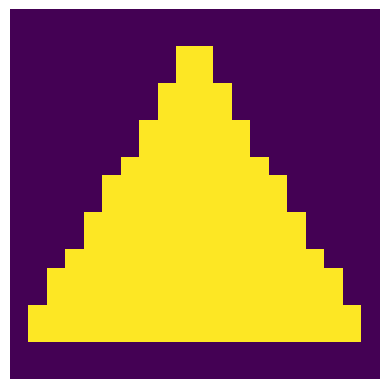

In [7]:
# spacial_res = 10
tri_mask = np.zeros([spacial_res,spacial_res])
uncentered_tri_mask = np.zeros([spacial_res,spacial_res])
diff = int((spacial_res - (spacial_res*3**.5)/2)/2)
for i in range(int((spacial_res*3**.5)//2)):
    for j in range(spacial_res):
        if i>=3**.5*abs(j-(spacial_res-1)/2):# or i<=2*abs(j-(spacial_res-1)/2):
            uncentered_tri_mask[i][j] = 1
tri_mask[diff:int((spacial_res*3**.5)//2)+1+diff] = uncentered_tri_mask[:int((spacial_res*3**.5)//2)+1]#This centers the triangle within the mask
# plt.imshow(tri_mask)
# plt.axis('off')

Sample Mask 

In [13]:
#see get_shape_chis.ipynb for a more step by step approach
image_path = "C:/Users/blake/Downloads/Sampletestpic.jpg"
raw_mask = get_mask(image_path, 140, 110, 55, show = False) #this is a mask that has as many pixels as the photo
sample_mask = change_mask_size(raw_mask, spacial_res)# this reduces the mask to spacial_res by spacial res pixels
sample_s = get_dx(image_path,len(raw_mask),show = False) #this is the actual side length of the sample
sides_lengths.append(sample_s*np.sqrt(all_shape_area/get_area(raw_mask,sample_s))) #(s_old/s_new)^2 = A_old/A_new
# print(sides_lengths)

Magnetic Fields of each shape

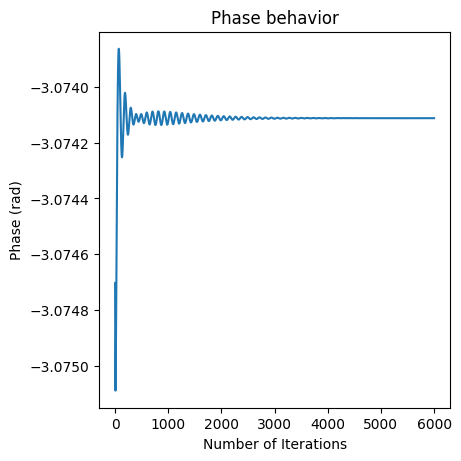

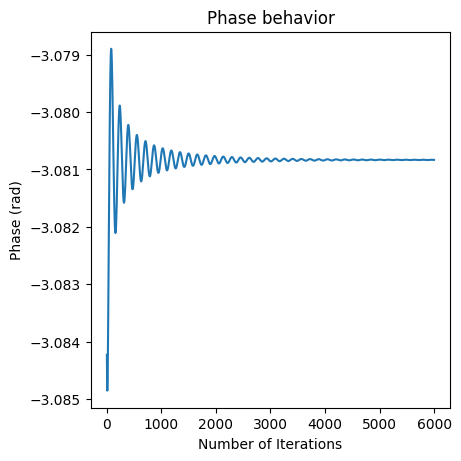

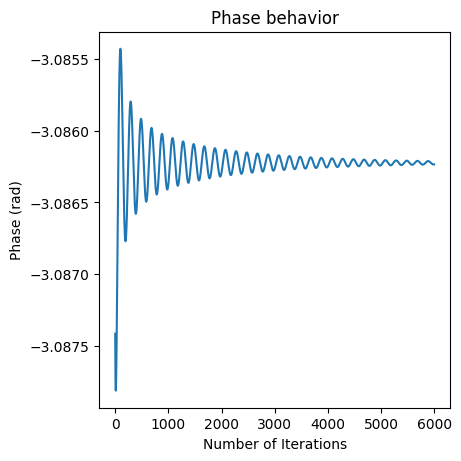

Time estimate:  12.965096026659012 hr,  777.9057615995407 min


In [16]:
magnetic_fields = np.zeros((len(sides_lengths),resistivity_res,spacial_res,spacial_res),dtype=np.complex128)
completed = False
for i, rho in enumerate(rhos):
    if i == 0:#this is an inital test for convergence of the phase and it also gives a time estimate. It is recommended to observe strong convergence at the lowest resisitiance to suggest convergnce for the resitivity range
        t1 = time.time()
        delta = get_skin_depth(rho,freq)
        magnetic_fields[0][i] = get_cylind_H(sides_lengths[0],delta,spacial_res-2) #circle
        magnetic_fields[1][i] = get_square_H(sides_lengths[1],delta,spacial_res-2) #square
        magnetic_fields[2][i] = get_shape_H_Show_Phase(tri_mask,sides_lengths[2],delta,iters) #tri
        magnetic_fields[3][i] = get_rect_H(sides_lengths[3],sides_lengths[3]/rec_ratio,delta,spacial_res - 2,iters,True) #rec
        magnetic_fields[4][i] = get_shape_H_Show_Phase(sample_mask,sides_lengths[4],delta,iters) #sample
        t2 = time.time()
        print('Time estimate: ', resistivity_res*(t2-t1)/3600, 'hr, ',resistivity_res*(t2-t1)/60, 'min')
    else:
        delta = get_skin_depth(rho,freq)
        magnetic_fields[0][i] = get_cylind_H(sides_lengths[0],delta,spacial_res-2) #circle
        magnetic_fields[1][i] = get_square_H(sides_lengths[1],delta,spacial_res-2) #square
        magnetic_fields[2][i] = get_shape_H(tri_mask,sides_lengths[2],delta,iters) #tri
        magnetic_fields[3][i] = get_rect_H(sides_lengths[3],sides_lengths[3]/rec_ratio,delta,spacial_res - 2,iters) #rec
        magnetic_fields[4][i] = get_shape_H(sample_mask,sides_lengths[4],delta,iters) #sample
completed = True

Save Magnetic Field Data

In [18]:
if completed:
    #save the rho values
    rho_file = open(save_path + str(freq) + 'RhoData.dat','w')
    rho_file.write('Resisitivity (Ohm m)\n')
    for rho in rhos:
        rho_file.write(str(rho)+'\n')
    rho_file.close()
    #Save Shape Data
    #the data structure is somewhat complicated. It is a 4D array. 
        #The first is shape, thats easy (index i) these are separated by unique files
        #second is the res value (index j) each res value will be a block of rows separated by a delimiter row of -1s
        #third is the rows index (index k) each row is separated by a \n
        #fourth is the col (index l) each col entry is separated by a \t
    for i, shape in enumerate(shapes):#shapes
        file_path = save_path + str(freq) + shape +'.dat'
        save_file = open(file_path,'w')
        for j in range(resistivity_res):#now in the shape file print each block
            for k in range(spacial_res):#this is the row
                for l in range(spacial_res-1):#this is each column entry for a given row
                    save_file.write(str(magnetic_fields[i][j][k][l])+'\t')
                    # if j == 0 and k==0 and magnetic_fields[i][j][k][l] != 1:
                    #     print(i,j,k,l)
                    #     print(str(magnetic_fields[i][j][k][l]))
                save_file.write(str(magnetic_fields[i][j][k][spacial_res-1])+'\n')
            for l in range(spacial_res-1):#delimitier row
                save_file.write('-1'+'\t')
            save_file.write('-1'+'\n')
        save_file.close()

Read in Data

In [19]:
#Read in the rho values
freq = 1.5e6
rho_path = save_path + str(freq) + 'RhoData.dat'
rho_data = np.genfromtxt(rho_path, delimiter='\t')
rhos2 = np.array(rho_data)[1:]
for i, shape in enumerate(shapes):
    shape_path = save_path + str(freq) + shape +'.dat'
    shape_data = np.genfromtxt(shape_path, delimiter='\t',dtype=np.complex128)
    if i == 0:
        spacial_res2 = len(shape_data[0])
        magnetic_fields2 = np.zeros((len(shapes),len(rhos2),spacial_res2,spacial_res2),dtype=np.complex128)
    j = 0
    k = 0
    l = 0
    for row in shape_data:
        if row[0] == -1:
            j += 1
            k = 0
        else:
            for l, col_entry in enumerate(row):
               magnetic_fields2[i][j][k][l] = np.complex128(col_entry)
            k += 1

Plot Magnetic Field

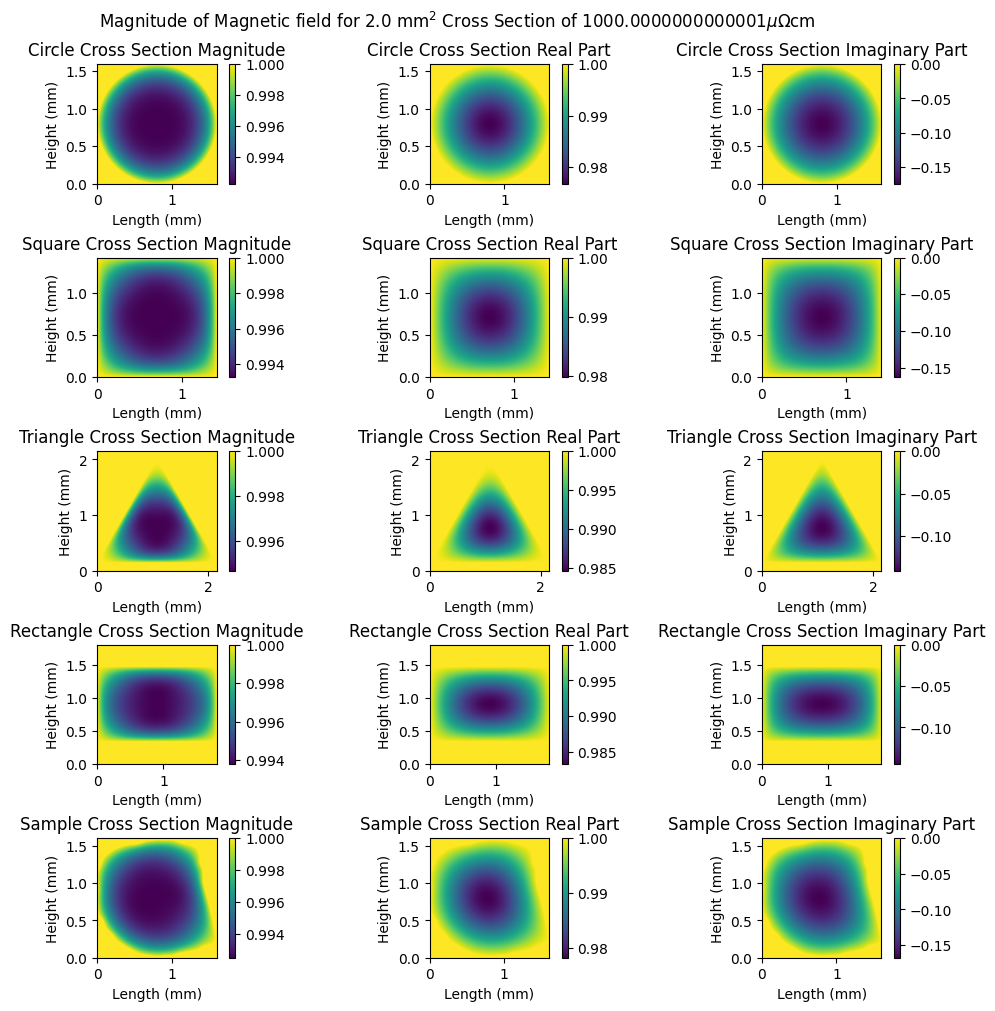

In [20]:
resistivity_to_plot = 1e-5 #ohm meters

ind = np.where(rhos2 == rhos2[np.logical_not(rhos2<resistivity_to_plot)][0]) #this is the index of the resistivity that we can
ind = int(ind[0][0])
fig = plt.figure(constrained_layout = True,figsize=(10,10))
circ1x = fig.add_subplot(5, 3, 1)
circ2x = fig.add_subplot(5, 3, 2)
circ3x = fig.add_subplot(5, 3, 3)

sq1x = fig.add_subplot(5, 3, 4)
sq2x = fig.add_subplot(5, 3, 5)
sq3x = fig.add_subplot(5, 3, 6)

tri1x = fig.add_subplot(5, 3, 7)
tri2x = fig.add_subplot(5, 3, 8)
tri3x = fig.add_subplot(5, 3, 9)

rec1x = fig.add_subplot(5, 3, 10)
rec2x = fig.add_subplot(5, 3, 11)
rec3x = fig.add_subplot(5, 3, 12)

sample1x = fig.add_subplot(5, 3, 13)
sample2x = fig.add_subplot(5, 3, 14)
sample3x = fig.add_subplot(5, 3, 15)

fig.suptitle('Magnitude of Magnetic field for '+str(round(all_shape_area*1e6,1))+r' mm$^2$ Cross Section of '+str(resistivity_to_plot*1e8)+r'$\mu \Omega$cm')

#circle
c1 = circ1x.imshow(np.absolute(magnetic_fields2[0][ind]),extent=[0, sides_lengths[0]*1e3, 0, sides_lengths[0]*1e3],vmin=np.absolute(magnetic_fields2[0][ind]).min(), vmax=np.absolute(magnetic_fields2[0][ind]).max())
fig.colorbar(c1, ax=circ1x)
circ1x.set_xlabel('Length (mm)')
circ1x.set_ylabel('Height (mm)')
circ1x.set_title('Circle Cross Section Magnitude')
c2 = circ2x.imshow(np.real(magnetic_fields2[0][ind]),extent=[0, sides_lengths[0]*1e3, 0, sides_lengths[0]*1e3],vmin=np.real(magnetic_fields2[0][ind]).min(), vmax=np.real(magnetic_fields2[0][ind]).max())
fig.colorbar(c2, ax=circ2x)
circ2x.set_xlabel('Length (mm)')
circ2x.set_ylabel('Height (mm)')
circ2x.set_title('Circle Cross Section Real Part')
c3 = circ3x.imshow(np.imag(magnetic_fields2[0][ind]),extent=[0, sides_lengths[0]*1e3, 0, sides_lengths[0]*1e3],vmin=np.imag(magnetic_fields2[0][ind]).min(), vmax=np.imag(magnetic_fields2[0][ind]).max())
fig.colorbar(c3, ax=circ3x)
circ3x.set_xlabel('Length (mm)')
circ3x.set_ylabel('Height (mm)')
circ3x.set_title('Circle Cross Section Imaginary Part')

#Square
fig.colorbar(sq1x.imshow(np.absolute(magnetic_fields2[1][ind]),extent=[0, sides_lengths[1]*1e3, 0, sides_lengths[1]*1e3],vmin=np.absolute(magnetic_fields2[1][ind]).min(), vmax=np.absolute(magnetic_fields2[1][ind]).max()), ax=sq1x)
sq1x.set_xlabel('Length (mm)')
sq1x.set_ylabel('Height (mm)')
sq1x.set_title('Square Cross Section Magnitude')
fig.colorbar(sq2x.imshow(np.real(magnetic_fields2[1][ind]),extent=[0, sides_lengths[1]*1e3, 0, sides_lengths[1]*1e3],vmin=np.real(magnetic_fields2[1][ind]).min(), vmax=np.real(magnetic_fields2[1][ind]).max()), ax=sq2x)
sq2x.set_xlabel('Length (mm)')
sq2x.set_ylabel('Height (mm)')
sq2x.set_title('Square Cross Section Real Part')
fig.colorbar(sq3x.imshow(np.imag(magnetic_fields2[1][ind]),extent=[0, sides_lengths[1]*1e3, 0, sides_lengths[1]*1e3],vmin=np.imag(magnetic_fields2[1][ind]).min(), vmax=np.imag(magnetic_fields2[1][ind]).max()), ax=sq3x)
sq3x.set_xlabel('Length (mm)')
sq3x.set_ylabel('Height (mm)')
sq3x.set_title('Square Cross Section Imaginary Part')

#Triangle
fig.colorbar(tri1x.imshow(np.absolute(magnetic_fields2[2][ind]),extent=[0, sides_lengths[2]*1e3, 0, sides_lengths[2]*1e3],vmin=np.absolute(magnetic_fields2[2][ind]).min(), vmax=np.absolute(magnetic_fields2[2][ind]).max()), ax=tri1x)
tri1x.set_xlabel('Length (mm)')
tri1x.set_ylabel('Height (mm)')
tri1x.set_title('Triangle Cross Section Magnitude')
fig.colorbar(tri2x.imshow(np.real(magnetic_fields2[2][ind]),extent=[0, sides_lengths[2]*1e3, 0, sides_lengths[2]*1e3],vmin=np.real(magnetic_fields2[2][ind]).min(), vmax=np.real(magnetic_fields2[2][ind]).max()), ax=tri2x)
tri2x.set_xlabel('Length (mm)')
tri2x.set_ylabel('Height (mm)')
tri2x.set_title('Triangle Cross Section Real Part')
fig.colorbar(tri3x.imshow(np.imag(magnetic_fields2[2][ind]),extent=[0, sides_lengths[2]*1e3, 0, sides_lengths[2]*1e3],vmin=np.imag(magnetic_fields2[2][ind]).min(), vmax=np.imag(magnetic_fields2[2][ind]).max()), ax=tri3x)
tri3x.set_xlabel('Length (mm)')
tri3x.set_ylabel('Height (mm)')
tri3x.set_title('Triangle Cross Section Imaginary Part')

#rectangle
fig.colorbar(rec1x.imshow(np.absolute(magnetic_fields2[3][ind]),extent=[0, sides_lengths[3]*1e3, 0, sides_lengths[3]*1e3],vmin=np.absolute(magnetic_fields2[3][ind]).min(), vmax=np.absolute(magnetic_fields2[3][ind]).max()), ax=rec1x)
rec1x.set_xlabel('Length (mm)')
rec1x.set_ylabel('Height (mm)')
rec1x.set_title('Rectangle Cross Section Magnitude')
fig.colorbar(rec2x.imshow(np.real(magnetic_fields2[3][ind]),extent=[0, sides_lengths[3]*1e3, 0, sides_lengths[3]*1e3],vmin=np.real(magnetic_fields2[3][ind]).min(), vmax=np.real(magnetic_fields2[3][ind]).max()), ax=rec2x)
rec2x.set_xlabel('Length (mm)')
rec2x.set_ylabel('Height (mm)')
rec2x.set_title('Rectangle Cross Section Real Part')
fig.colorbar(rec3x.imshow(np.imag(magnetic_fields2[3][ind]),extent=[0, sides_lengths[3]*1e3, 0, sides_lengths[3]*1e3],vmin=np.imag(magnetic_fields2[3][ind]).min(), vmax=np.imag(magnetic_fields2[3][ind]).max()), ax=rec3x)
rec3x.set_xlabel('Length (mm)')
rec3x.set_ylabel('Height (mm)')
rec3x.set_title('Rectangle Cross Section Imaginary Part')

#Sample
fig.colorbar(sample1x.imshow(np.absolute(magnetic_fields2[4][ind]),extent=[0, sides_lengths[4]*1e3, 0, sides_lengths[4]*1e3],vmin=np.absolute(magnetic_fields2[4][ind]).min(), vmax=np.absolute(magnetic_fields2[4][ind]).max()), ax=sample1x)
sample1x.set_xlabel('Length (mm)')
sample1x.set_ylabel('Height (mm)')
sample1x.set_title('Sample Cross Section Magnitude')
fig.colorbar(sample2x.imshow(np.real(magnetic_fields2[4][ind]),extent=[0, sides_lengths[4]*1e3, 0, sides_lengths[4]*1e3],vmin=np.real(magnetic_fields2[4][ind]).min(), vmax=np.real(magnetic_fields2[4][ind]).max()), ax=sample2x)
sample2x.set_xlabel('Length (mm)')
sample2x.set_ylabel('Height (mm)')
sample2x.set_title('Sample Cross Section Real Part')
fig.colorbar(sample3x.imshow(np.imag(magnetic_fields2[4][ind]),extent=[0, sides_lengths[4]*1e3, 0, sides_lengths[4]*1e3],vmin=np.imag(magnetic_fields2[4][ind]).min(), vmax=np.imag(magnetic_fields2[4][ind]).max()), ax=sample3x)
sample3x.set_xlabel('Length (mm)')
sample3x.set_ylabel('Height (mm)')
_=sample3x.set_title('Sample Cross Section Imaginary Part')

#TODO
#make distance axises same units
#dynmaically change spacial resolution
#better heruistics for convergence
#implelemting convergne detection
#look into fitting oscccilator

Adjust x to be the scaled the same

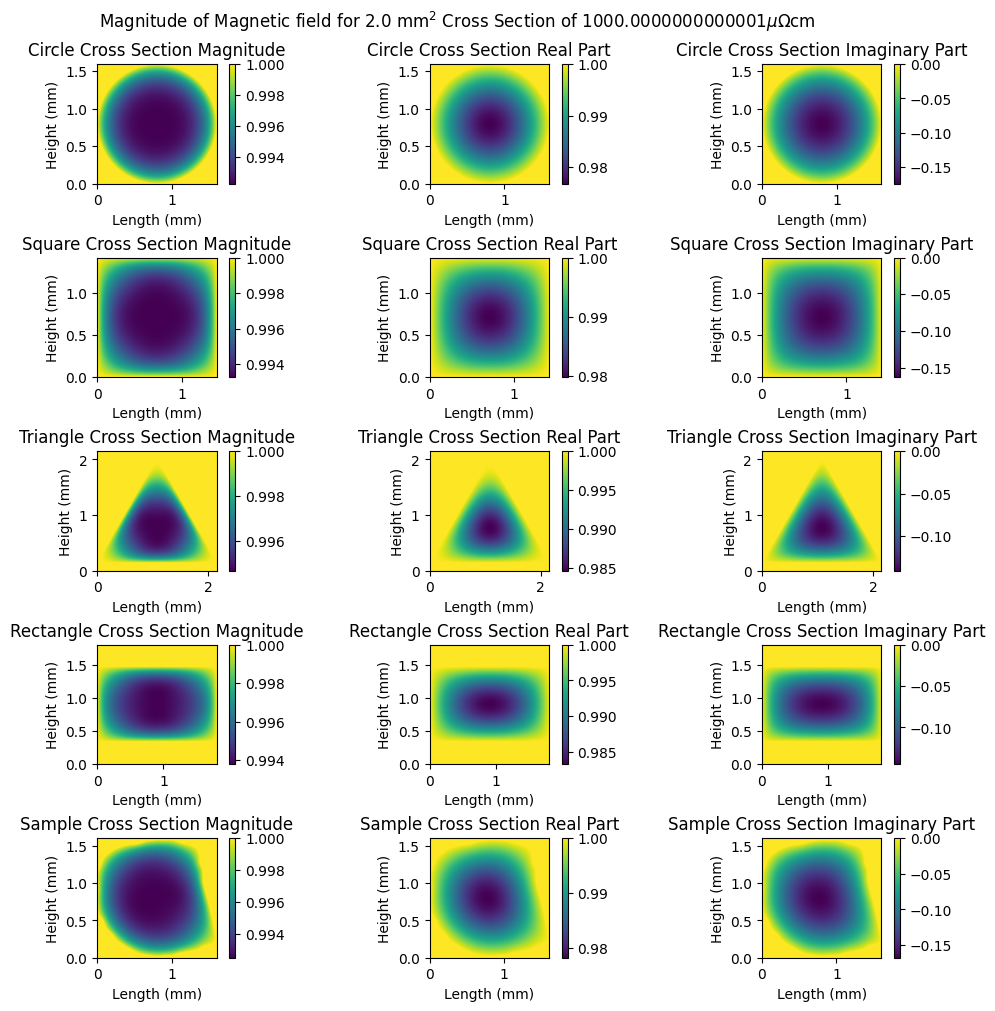

In [21]:
resistivity_to_plot = 1e-5 #ohm meters

ind = np.where(rhos2 == rhos2[np.logical_not(rhos2<resistivity_to_plot)][0]) #this is the index of the resistivity that we can
ind = int(ind[0][0])
fig = plt.figure(constrained_layout = True,figsize=(10,10))
circ1x = fig.add_subplot(5, 3, 1)
circ2x = fig.add_subplot(5, 3, 2)
circ3x = fig.add_subplot(5, 3, 3)

sq1x = fig.add_subplot(5, 3, 4)
sq2x = fig.add_subplot(5, 3, 5)
sq3x = fig.add_subplot(5, 3, 6)

tri1x = fig.add_subplot(5, 3, 7)
tri2x = fig.add_subplot(5, 3, 8)
tri3x = fig.add_subplot(5, 3, 9)

rec1x = fig.add_subplot(5, 3, 10)
rec2x = fig.add_subplot(5, 3, 11)
rec3x = fig.add_subplot(5, 3, 12)

sample1x = fig.add_subplot(5, 3, 13)
sample2x = fig.add_subplot(5, 3, 14)
sample3x = fig.add_subplot(5, 3, 15)

fig.suptitle('Magnitude of Magnetic field for '+str(round(all_shape_area*1e6,1))+r' mm$^2$ Cross Section of '+str(resistivity_to_plot*1e8)+r'$\mu \Omega$cm')

#circle
c1 = circ1x.imshow(np.absolute(magnetic_fields2[0][ind]),extent=[0, sides_lengths[0]*1e3, 0, sides_lengths[0]*1e3],vmin=np.absolute(magnetic_fields2[0][ind]).min(), vmax=np.absolute(magnetic_fields2[0][ind]).max())
fig.colorbar(c1, ax=circ1x)
circ1x.set_xlabel('Length (mm)')
circ1x.set_ylabel('Height (mm)')
circ1x.set_title('Circle Cross Section Magnitude')
c2 = circ2x.imshow(np.real(magnetic_fields2[0][ind]),extent=[0, sides_lengths[0]*1e3, 0, sides_lengths[0]*1e3],vmin=np.real(magnetic_fields2[0][ind]).min(), vmax=np.real(magnetic_fields2[0][ind]).max())
fig.colorbar(c2, ax=circ2x)
circ2x.set_xlabel('Length (mm)')
circ2x.set_ylabel('Height (mm)')
circ2x.set_title('Circle Cross Section Real Part')
c3 = circ3x.imshow(np.imag(magnetic_fields2[0][ind]),extent=[0, sides_lengths[0]*1e3, 0, sides_lengths[0]*1e3],vmin=np.imag(magnetic_fields2[0][ind]).min(), vmax=np.imag(magnetic_fields2[0][ind]).max())
fig.colorbar(c3, ax=circ3x)
circ3x.set_xlabel('Length (mm)')
circ3x.set_ylabel('Height (mm)')
circ3x.set_title('Circle Cross Section Imaginary Part')

#Square
fig.colorbar(sq1x.imshow(np.absolute(magnetic_fields2[1][ind]),extent=[0, sides_lengths[1]*1e3, 0, sides_lengths[1]*1e3],vmin=np.absolute(magnetic_fields2[1][ind]).min(), vmax=np.absolute(magnetic_fields2[1][ind]).max()), ax=sq1x)
sq1x.set_xlabel('Length (mm)')
sq1x.set_ylabel('Height (mm)')
sq1x.set_title('Square Cross Section Magnitude')
fig.colorbar(sq2x.imshow(np.real(magnetic_fields2[1][ind]),extent=[0, sides_lengths[1]*1e3, 0, sides_lengths[1]*1e3],vmin=np.real(magnetic_fields2[1][ind]).min(), vmax=np.real(magnetic_fields2[1][ind]).max()), ax=sq2x)
sq2x.set_xlabel('Length (mm)')
sq2x.set_ylabel('Height (mm)')
sq2x.set_title('Square Cross Section Real Part')
fig.colorbar(sq3x.imshow(np.imag(magnetic_fields2[1][ind]),extent=[0, sides_lengths[1]*1e3, 0, sides_lengths[1]*1e3],vmin=np.imag(magnetic_fields2[1][ind]).min(), vmax=np.imag(magnetic_fields2[1][ind]).max()), ax=sq3x)
sq3x.set_xlabel('Length (mm)')
sq3x.set_ylabel('Height (mm)')
sq3x.set_title('Square Cross Section Imaginary Part')

#Triangle
fig.colorbar(tri1x.imshow(np.absolute(magnetic_fields2[2][ind]),extent=[0, sides_lengths[2]*1e3, 0, sides_lengths[2]*1e3],vmin=np.absolute(magnetic_fields2[2][ind]).min(), vmax=np.absolute(magnetic_fields2[2][ind]).max()), ax=tri1x)
tri1x.set_xlabel('Length (mm)')
tri1x.set_ylabel('Height (mm)')
tri1x.set_title('Triangle Cross Section Magnitude')
fig.colorbar(tri2x.imshow(np.real(magnetic_fields2[2][ind]),extent=[0, sides_lengths[2]*1e3, 0, sides_lengths[2]*1e3],vmin=np.real(magnetic_fields2[2][ind]).min(), vmax=np.real(magnetic_fields2[2][ind]).max()), ax=tri2x)
tri2x.set_xlabel('Length (mm)')
tri2x.set_ylabel('Height (mm)')
tri2x.set_title('Triangle Cross Section Real Part')
fig.colorbar(tri3x.imshow(np.imag(magnetic_fields2[2][ind]),extent=[0, sides_lengths[2]*1e3, 0, sides_lengths[2]*1e3],vmin=np.imag(magnetic_fields2[2][ind]).min(), vmax=np.imag(magnetic_fields2[2][ind]).max()), ax=tri3x)
tri3x.set_xlabel('Length (mm)')
tri3x.set_ylabel('Height (mm)')
tri3x.set_title('Triangle Cross Section Imaginary Part')

#rectangle
fig.colorbar(rec1x.imshow(np.absolute(magnetic_fields2[3][ind]),extent=[0, sides_lengths[3]*1e3, 0, sides_lengths[3]*1e3],vmin=np.absolute(magnetic_fields2[3][ind]).min(), vmax=np.absolute(magnetic_fields2[3][ind]).max()), ax=rec1x)
rec1x.set_xlabel('Length (mm)')
rec1x.set_ylabel('Height (mm)')
rec1x.set_title('Rectangle Cross Section Magnitude')
fig.colorbar(rec2x.imshow(np.real(magnetic_fields2[3][ind]),extent=[0, sides_lengths[3]*1e3, 0, sides_lengths[3]*1e3],vmin=np.real(magnetic_fields2[3][ind]).min(), vmax=np.real(magnetic_fields2[3][ind]).max()), ax=rec2x)
rec2x.set_xlabel('Length (mm)')
rec2x.set_ylabel('Height (mm)')
rec2x.set_title('Rectangle Cross Section Real Part')
fig.colorbar(rec3x.imshow(np.imag(magnetic_fields2[3][ind]),extent=[0, sides_lengths[3]*1e3, 0, sides_lengths[3]*1e3],vmin=np.imag(magnetic_fields2[3][ind]).min(), vmax=np.imag(magnetic_fields2[3][ind]).max()), ax=rec3x)
rec3x.set_xlabel('Length (mm)')
rec3x.set_ylabel('Height (mm)')
rec3x.set_title('Rectangle Cross Section Imaginary Part')

#Sample
fig.colorbar(sample1x.imshow(np.absolute(magnetic_fields2[4][ind]),extent=[0, sides_lengths[4]*1e3, 0, sides_lengths[4]*1e3],vmin=np.absolute(magnetic_fields2[4][ind]).min(), vmax=np.absolute(magnetic_fields2[4][ind]).max()), ax=sample1x)
sample1x.set_xlabel('Length (mm)')
sample1x.set_ylabel('Height (mm)')
sample1x.set_title('Sample Cross Section Magnitude')
fig.colorbar(sample2x.imshow(np.real(magnetic_fields2[4][ind]),extent=[0, sides_lengths[4]*1e3, 0, sides_lengths[4]*1e3],vmin=np.real(magnetic_fields2[4][ind]).min(), vmax=np.real(magnetic_fields2[4][ind]).max()), ax=sample2x)
sample2x.set_xlabel('Length (mm)')
sample2x.set_ylabel('Height (mm)')
sample2x.set_title('Sample Cross Section Real Part')
fig.colorbar(sample3x.imshow(np.imag(magnetic_fields2[4][ind]),extent=[0, sides_lengths[4]*1e3, 0, sides_lengths[4]*1e3],vmin=np.imag(magnetic_fields2[4][ind]).min(), vmax=np.imag(magnetic_fields2[4][ind]).max()), ax=sample3x)
sample3x.set_xlabel('Length (mm)')
sample3x.set_ylabel('Height (mm)')
_=sample3x.set_title('Sample Cross Section Imaginary Part')

Find the Magnetic Susceptibility

In [22]:
chis = np.zeros((len(sides_lengths),resistivity_res),dtype=np.complex128)
for i, shape_fields in enumerate(magnetic_fields2):
    for j, res in enumerate(shape_fields):
        chis[i][j] = double_Integral(shape_fields[j],sides_lengths[i])/sides_lengths[i]**2-1

Plot Magnetic Susceptibility

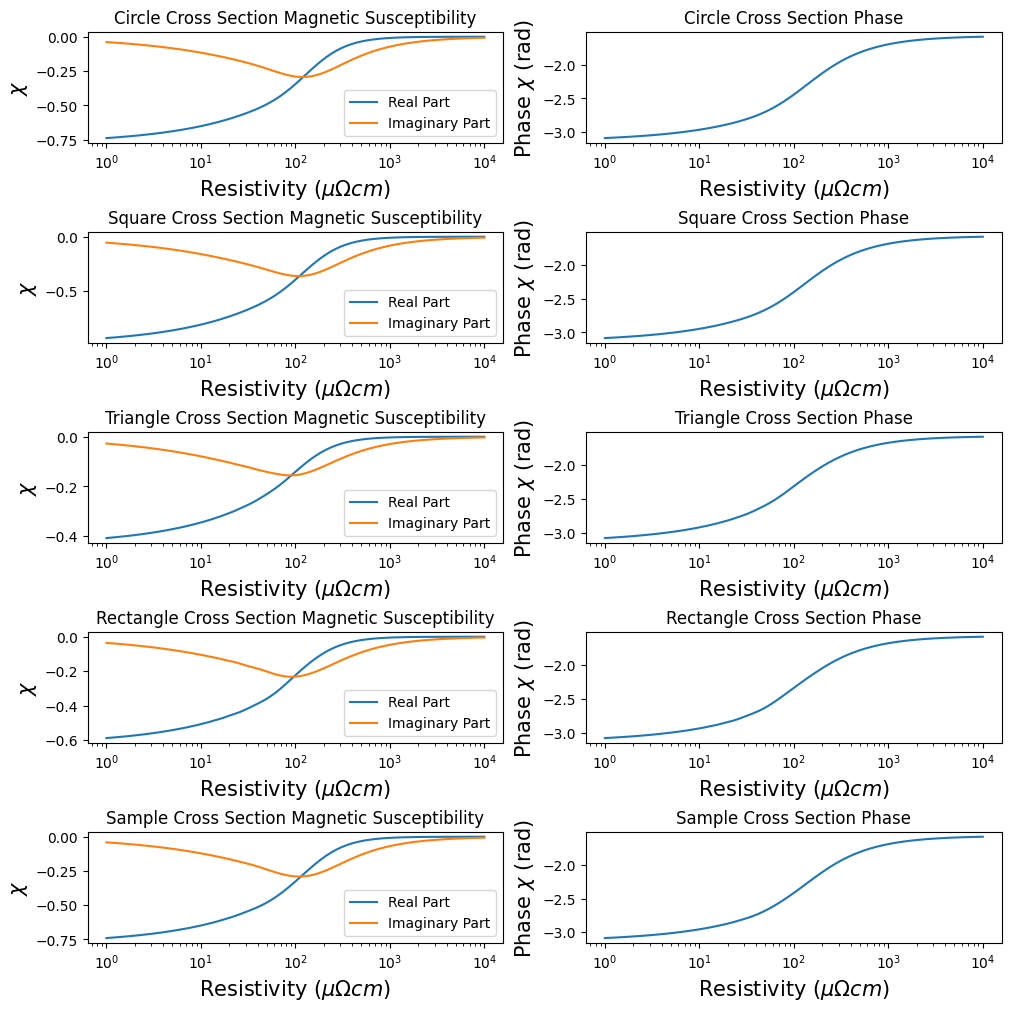

In [23]:
fig2 = plt.figure(constrained_layout = True, figsize=(10,10))
circ1x = fig2.add_subplot(5, 2, 1)
circ2x = fig2.add_subplot(5, 2, 2)

sq1x = fig2.add_subplot(5, 2, 3)
sq2x = fig2.add_subplot(5, 2, 4)

tri1x = fig2.add_subplot(5, 2, 5)
tri2x = fig2.add_subplot(5, 2, 6)

rec1x = fig2.add_subplot(5, 2, 7)
rec2x = fig2.add_subplot(5, 2, 8)

sample1x = fig2.add_subplot(5, 2, 9)
sample2x = fig2.add_subplot(5, 2, 10)

#circle
circ1x.plot(rhos2*1e8,np.real(chis[0]))
circ1x.plot(rhos2*1e8,np.imag(chis[0]))
circ1x.legend(['Real Part','Imaginary Part'])
circ1x.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
circ1x.set_ylabel(r'$\chi$',fontsize = 15)
circ1x.set_title('Circle Cross Section Magnetic Susceptibility')
circ1x.set_xscale('log')
circ2x.plot(rhos2*1e8,np.angle(chis[0]))
circ2x.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
circ2x.set_ylabel(r'Phase $\chi$ (rad)',fontsize = 15)
circ2x.set_title('Circle Cross Section Phase')
circ2x.set_xscale('log')

#square
sq1x.plot(rhos2*1e8,np.real(chis[1]))
sq1x.plot(rhos2*1e8,np.imag(chis[1]))
sq1x.legend(['Real Part','Imaginary Part'])
sq1x.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
sq1x.set_ylabel(r'$\chi$',fontsize = 15)
sq1x.set_title('Square Cross Section Magnetic Susceptibility')
sq1x.set_xscale('log')
sq2x.plot(rhos2*1e8,np.angle(chis[1]))
sq2x.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
sq2x.set_ylabel(r'Phase $\chi$ (rad)',fontsize = 15)
sq2x.set_title('Square Cross Section Phase')
sq2x.set_xscale('log')

#triangle
tri1x.plot(rhos2*1e8,np.real(chis[2]))
tri1x.plot(rhos2*1e8,np.imag(chis[2]))
tri1x.legend(['Real Part','Imaginary Part'])
tri1x.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
tri1x.set_ylabel(r'$\chi$',fontsize = 15)
tri1x.set_title('Triangle Cross Section Magnetic Susceptibility')
tri1x.set_xscale('log')
tri2x.plot(rhos2*1e8,np.angle(chis[2]))
tri2x.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
tri2x.set_ylabel(r'Phase $\chi$ (rad)',fontsize = 15)
tri2x.set_title('Triangle Cross Section Phase')
tri2x.set_xscale('log')

#rectangle
rec1x.plot(rhos2*1e8,np.real(chis[3]))
rec1x.plot(rhos2*1e8,np.imag(chis[3]))
rec1x.legend(['Real Part','Imaginary Part'])
rec1x.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
rec1x.set_ylabel(r'$\chi$',fontsize = 15)
rec1x.set_title('Rectangle Cross Section Magnetic Susceptibility')
rec1x.set_xscale('log')
rec2x.plot(rhos2*1e8,np.angle(chis[3]))
rec2x.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
rec2x.set_ylabel(r'Phase $\chi$ (rad)',fontsize = 15)
rec2x.set_title('Rectangle Cross Section Phase')
rec2x.set_xscale('log')

#sample
sample1x.plot(rhos2*1e8,np.real(chis[4]))
sample1x.plot(rhos2*1e8,np.imag(chis[4]))
sample1x.legend(['Real Part','Imaginary Part'])
sample1x.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
sample1x.set_ylabel(r'$\chi$',fontsize = 15)
sample1x.set_title('Sample Cross Section Magnetic Susceptibility')
sample1x.set_xscale('log')
sample2x.plot(rhos2*1e8,np.angle(chis[4]))
sample2x.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
sample2x.set_ylabel(r'Phase $\chi$ (rad)',fontsize = 15)
sample2x.set_title('Sample Cross Section Phase')
sample2x.set_xscale('log')

Combined Chi

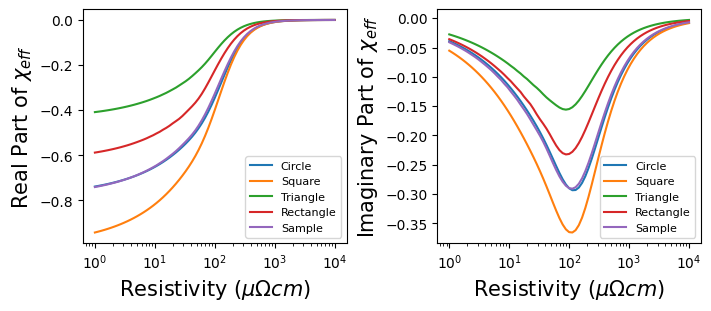

In [24]:
fig2 = plt.figure(constrained_layout = True, figsize=(7,3))
ax = fig2.add_subplot(1, 2, 1)
bx = fig2.add_subplot(1, 2, 2)

#circle
ax.plot(rhos2*1e8,np.real(chis[0]),label = 'Circle')
bx.plot(rhos2*1e8,np.imag(chis[0]),label = 'Circle')
ax.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
ax.set_ylabel(r'Real Part of $\chi_{eff}$',fontsize = 15)
# ax.set_title('Circle Cross Section Magnetic Susceptibility')
ax.set_xscale('log')

bx.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
bx.set_ylabel(r'Imaginary Part of $\chi_{eff}$',fontsize = 15)
# bx.set_title('Circle Cross Section Phase')
bx.set_xscale('log')

#square
ax.plot(rhos2*1e8,np.real(chis[1]),label = 'Square')
bx.plot(rhos2*1e8,np.imag(chis[1]),label = 'Square')
#triangle
ax.plot(rhos2*1e8,np.real(chis[2]),label = 'Triangle')
bx.plot(rhos2*1e8,np.imag(chis[2]),label = 'Triangle')
#rectangle
ax.plot(rhos2*1e8,np.real(chis[3]),label = 'Rectangle')
bx.plot(rhos2*1e8,np.imag(chis[3]),label = 'Rectangle')

#sample
ax.plot(rhos2*1e8,np.real(chis[4]),label = 'Sample')
bx.plot(rhos2*1e8,np.imag(chis[4]),label = 'Sample')
ax.legend(fontsize = 8)
bx.legend(fontsize = 8)

Combined Plot

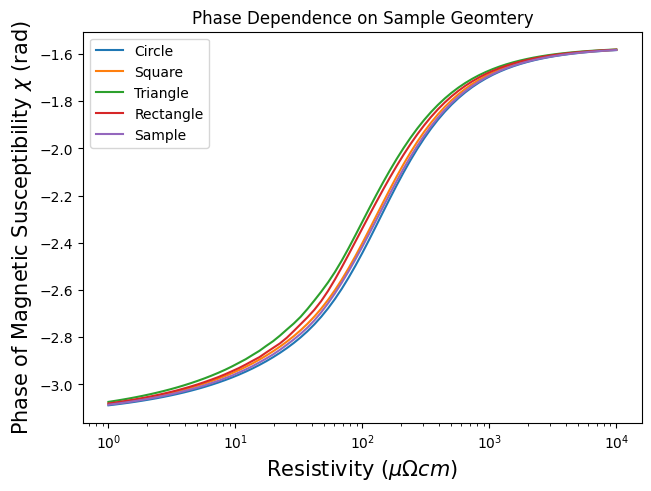

In [25]:
fig3 = plt.figure(constrained_layout = True)
ax = fig3.add_subplot(1, 1, 1)
# print(chis)
for i in range(len(chis)):
    if i<5:
        ax.plot(rhos2*1e8,np.angle(chis[i]))
    # print(np.angle(chis[i]))
ax.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
ax.set_ylabel(r'Phase of Magnetic Susceptibility $\chi$ (rad)',fontsize = 15)
ax.set_title('Phase Dependence on Sample Geomtery')
ax.set_xscale('log')
_ = ax.legend(['Circle','Square','Triangle','Rectangle','Sample'])

Difference Plotting

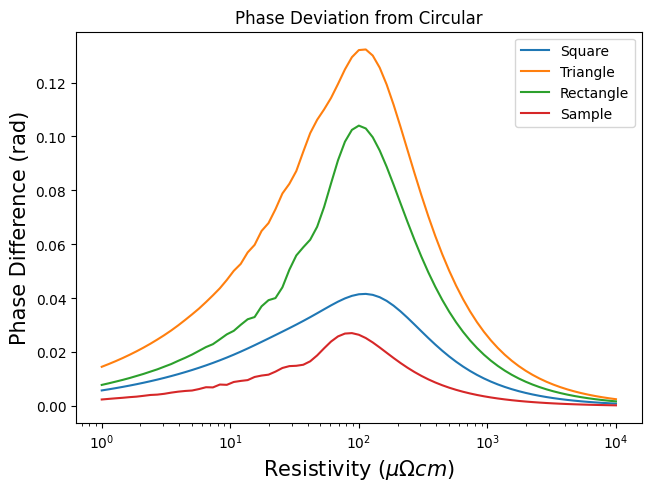

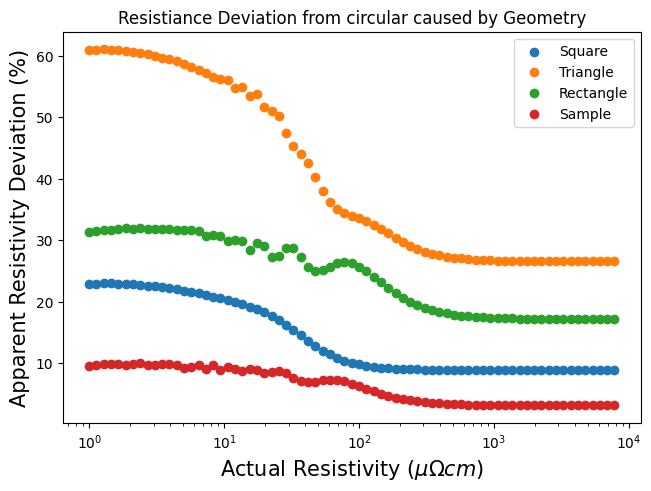

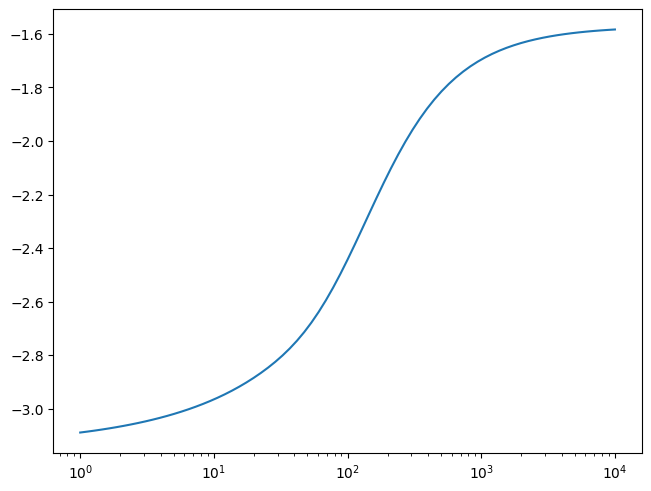

In [26]:
fig4 = plt.figure(constrained_layout = True)
ax = fig4.add_subplot(1, 1, 1)
for i in range(1,len(chis)):
    ax.plot(rhos2*1e8,np.angle(chis[i])-np.angle(chis[0]))
ax.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
ax.set_ylabel(r'Phase Difference (rad)',fontsize = 15)
ax.set_title('Phase Deviation from Circular')
ax.set_xscale('log')
_ = ax.legend(['Square','Triangle','Rectangle','Sample'])

fig5 = plt.figure(constrained_layout = True)
bx = fig5.add_subplot(1, 1, 1)
for i in range(1,len(chis)):
    bx.scatter(rhos2[:-2]*1e8,(np.interp(np.angle(chis[i][:-2]),np.angle(chis[0]),rhos2)-rhos2[:-2])/rhos2[:-2]*100)
bx.set_xlabel(r'Actual Resistivity ($\mu \Omega cm$)',fontsize = 15)
bx.set_ylabel(r'Apparent Resistivity Deviation (%)',fontsize = 15)
bx.set_title('Resistiance Deviation from circular caused by Geometry')
bx.set_xscale('log')
_ = bx.legend(['Square','Triangle','Rectangle','Sample'])

fig6 = plt.figure(constrained_layout = True)
cx = fig6.add_subplot(1, 1, 1)
cx.plot(rhos2*1e8,np.angle(chis[0]))
cx.set_xscale('log')

Area Check

In [27]:
circ_mask = np.zeros([spacial_res+2,spacial_res+2],dtype=np.float64)  # initialize the mask to ones
for i in range(1,spacial_res+1):
    for j in range(1,spacial_res+1):
        if np.sqrt((i-(spacial_res+1)/2)**2 + (j-(spacial_res+1)/2)**2)*2 <= spacial_res: #this makes a circle
            circ_mask[i, j] = 1 # ouinside is ones

sq_mask = np.ones([spacial_res+2,spacial_res+2],dtype=np.float64)
sq_mask[0] = np.array([0]*len(sq_mask))
sq_mask[-1] = np.array([0]*len(sq_mask))
tsq_mask = np.transpose(sq_mask)
tsq_mask[0] = np.array([0]*len(sq_mask))
tsq_mask[-1] = np.array([0]*len(sq_mask))
sq_mask = np.transpose(tsq_mask)

rec_mask = np.zeros([spacial_res+2,spacial_res+2],dtype=np.float64)
for i in range(1, spacial_res+1):
    if abs(i/(spacial_res+1)-.5)< .5/rec_ratio: #so the difference from the center point (.5) is ratio/2 or less for each side
        row = [1]*(spacial_res + 2)
        row[0] = 0
        row[-1] = 0
        rec_mask[i] = np.array([row])

# fig = plt.figure(constrained_layout = True)
# ax = fig.add_subplot(1, 1, 1)
# ax.imshow(rec_mask)
print('Circle Area =', get_area(circ_mask,sides_lengths[0]))
print('Square Area =', get_area(sq_mask,sides_lengths[1]))
print('Triangle Area =', get_area(tri_mask,sides_lengths[2]))
print('Rectangle Area =', get_area(rec_mask,sides_lengths[3]))
print('Sample Area =', get_area(sample_mask,sides_lengths[4]))

Circle Area = 2.0005644813640422e-06
Square Area = 2e-06
Triangle Area = 2.0151132869922903e-06
Rectangle Area = 2.0004783860907785e-06
Sample Area = 2.0187075634376927e-06
